In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from scipy import stats as st


In [2]:
data = pd.read_csv("data/actual/100.csv")
# data = pd.read_csv("data/data_616.csv")
data = data.iloc[:,1:]
vars = list(data.columns)
n_vars = len(vars)

In [3]:
import sys
from pathlib import Path
import os
code_path = Path(os.getcwd())


In [4]:
path = code_path.joinpath('data/actual')
files = [f for f in os.listdir(path) if os.path.isfile(path.joinpath(f)) and Path(f).suffix == '.csv' ]

In [5]:
data_files = {i: pd.read_csv(path.joinpath(file)).iloc[:,1:] for i, file in enumerate(files)}

In [6]:
means = np.array([np.mean(data) for data in data_files.values()])

In [7]:
# mean_n = 3
# d_means = means[:,mean_n]
# rest_means = means[:,[i for i in range(0,means.shape[1]) if i !=mean_n]]
# rest_means.shape

In [8]:
# means


In [9]:
colors = np.random.randint(0,255,(n_vars,3))/255

In [10]:
print(colors)

[[0.1372549  0.71372549 0.9372549 ]
 [0.98039216 0.65098039 0.82352941]
 [0.69411765 0.5254902  0.94901961]
 [0.21176471 0.25490196 0.74117647]
 [0.17647059 0.44313725 0.5372549 ]
 [0.69803922 0.9254902  0.03921569]]


In [11]:
# Mutual information score
import sklearn.feature_selection as sf

mutual_score = np.zeros((n_vars,n_vars))

for i in range(n_vars):
    for j in range(n_vars):
        x = np.array(data[vars[i]]).reshape((-1,1))
        y = np.array(data[vars[j]])
        mutual_score[i,j] = np.round(sf.mutual_info_regression(x,y),10)

In [12]:
[print(i,file) for i,file in enumerate(files)];

0 100.csv
1 200.csv
2 30-B=0.csv
3 30-C=0.csv
4 30-C=1.csv
5 30-D=-2.csv
6 40-D=-2.csv
7 50-A=1.3.csv
8 50-E=2.csv
9 50-F=-1.5.csv
10 50-F=2.csv
11 70-D=1.csv
12 70-E=2-F=2.csv
13 combined_noint.csv
14 D_combined.csv


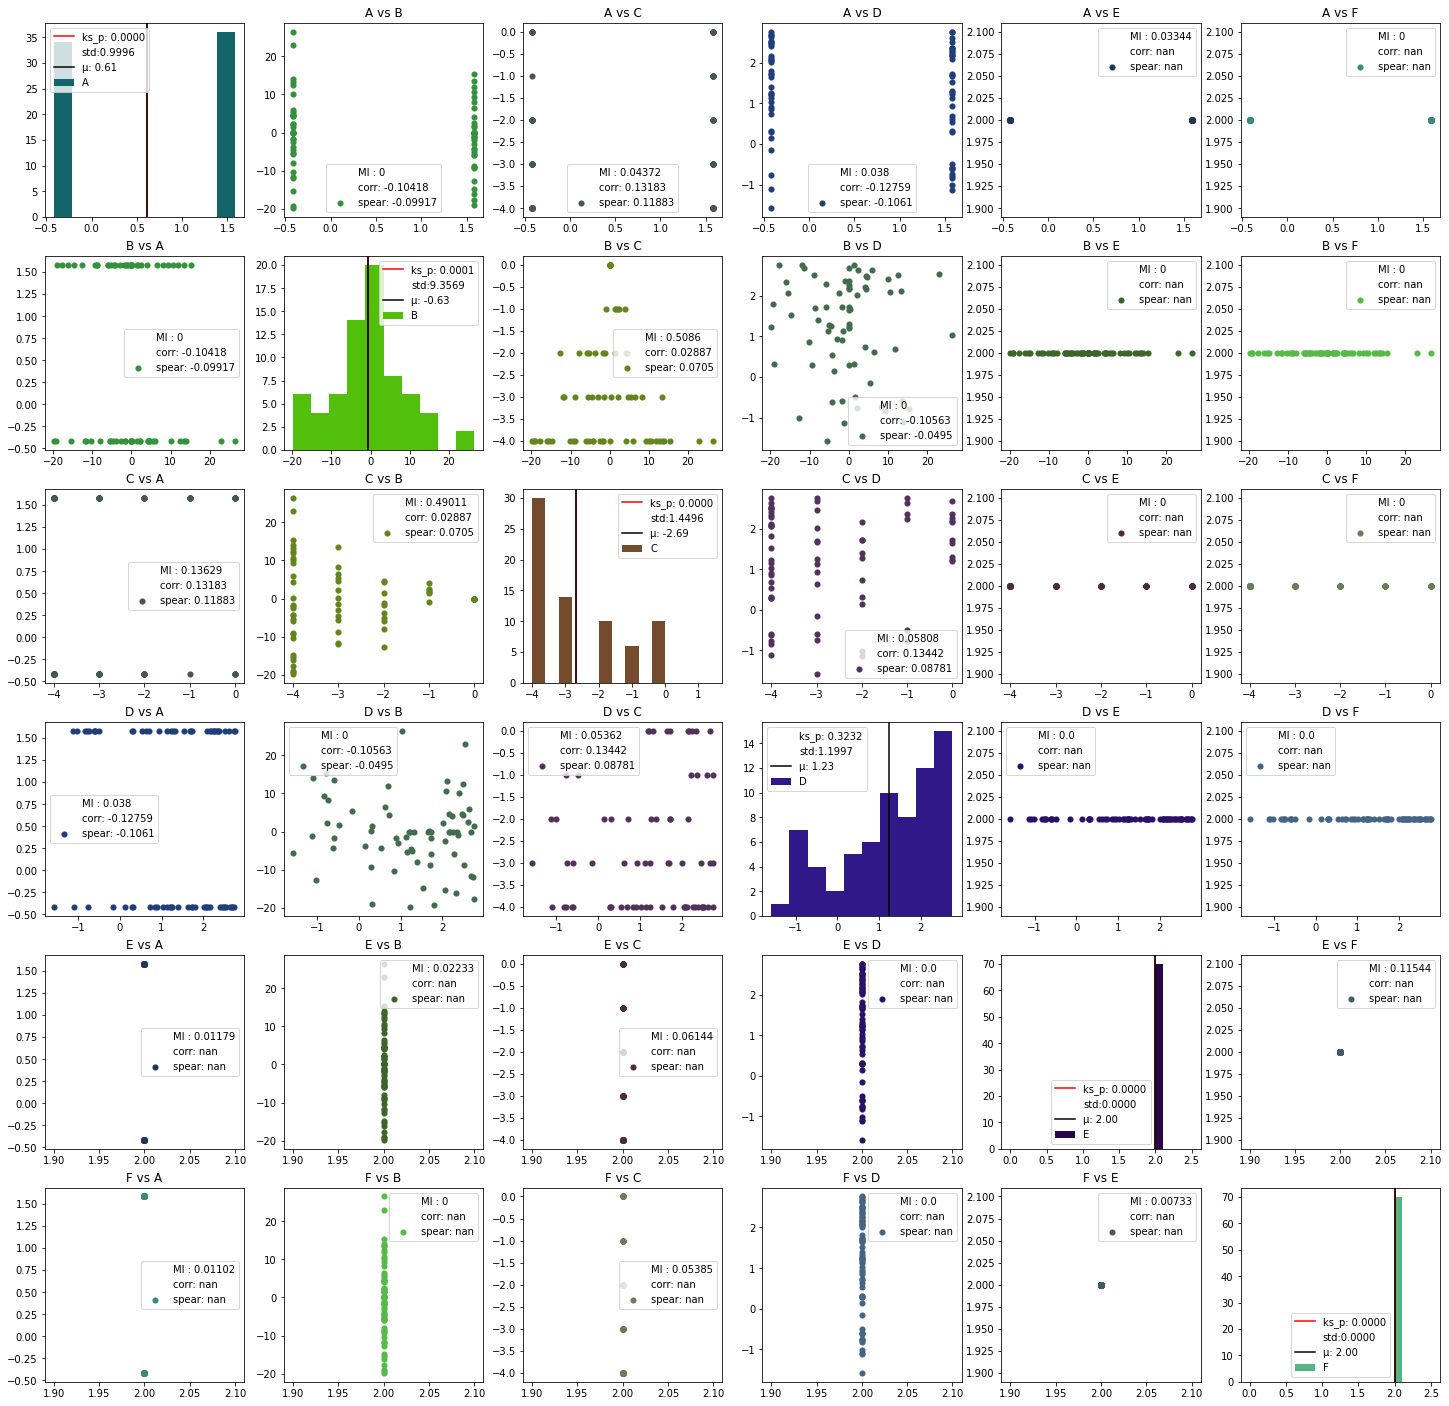

In [82]:
# Pairwise plots
def pairwise_plots(data, combarison_data = None, files = files, file_number = None):
    n_vars = len(list(data.columns))
    colors = np.random.randint(0,255,(n_vars,3))/255
    fig, axs = plt.subplots(n_vars,n_vars,figsize=(25,25))
    names = ["A","B","C","D","E","F"]


    for i,axs_i in enumerate(axs):
        for j,ax in enumerate(axs_i):
            
            x = np.array(data[vars[i]])
            y = np.array(data[vars[j]])

            if i != j:
                ax.scatter(x,y,linewidths =0.1,color=(colors[i]+colors[j])/2)
                ax.axvline(np.mean(x), color='black', alpha = 0)
                ax.axvline(np.mean(x), color='blue', alpha = 0)

                ax.set_title(f'{vars[i]} vs {vars[j]}')

                mutual_score = np.round(sf.mutual_info_regression(x.reshape(-1,1),y),5)
                corr = np.round(np.corrcoef(x,y),5)
                spearman = np.round(st.spearmanr(x,y),5)
                ax.legend(labels=[f'MI : {mutual_score[0]}',f"corr: {corr[0,1]}",f"spear: {spearman[0]}"])
            else:
                ax.hist(data[vars[i]],color=colors[i])
    
                if combarison_data is not None:
                    comparison_p_value = st.ks_2samp(combarison_data[names[i]],data[vars[i]])[1]
                    alpha = 1 if comparison_p_value < 0.05 else 0
                    ax.axvline(np.mean(data[vars[i]]), color='red', alpha = alpha)
                    ax.axvline(np.std(data[vars[i]]), color='black', alpha = 0)
                    ax.axvline(np.mean(data[vars[i]]), color='black')

                    ax.legend(labels=[f'ks_p: {comparison_p_value:.4f}',f"std:{np.std(data[vars[i]]):.4f}",f'μ: {np.mean(data[vars[i]]):.2f}', vars[i]])
                    # ax.legend(labels=[f'ks_p: {comparison_p_value:.4f}',f'μ: {np.mean(data[vars[i]]):.2f}', vars[i]])
                    None
                else:
                    ax.axvline(np.mean(data[vars[i]]), color='black')
                    ax.legend(labels=[ f'μ: {np.mean(data[vars[i]]):.2f}', vars[i]])

    if file_number is not None:
        fig.suptitle(f"{files[file_number][:-4]}",fontsize = 40,y=0.93)
    

import warnings
warnings.filterwarnings("ignore")

pairwise_plots(data_files[12], combarison_data = data_files[files.index("combined_noint.csv")])

# pairwise_plots(data_files[2])
# data_files[11]


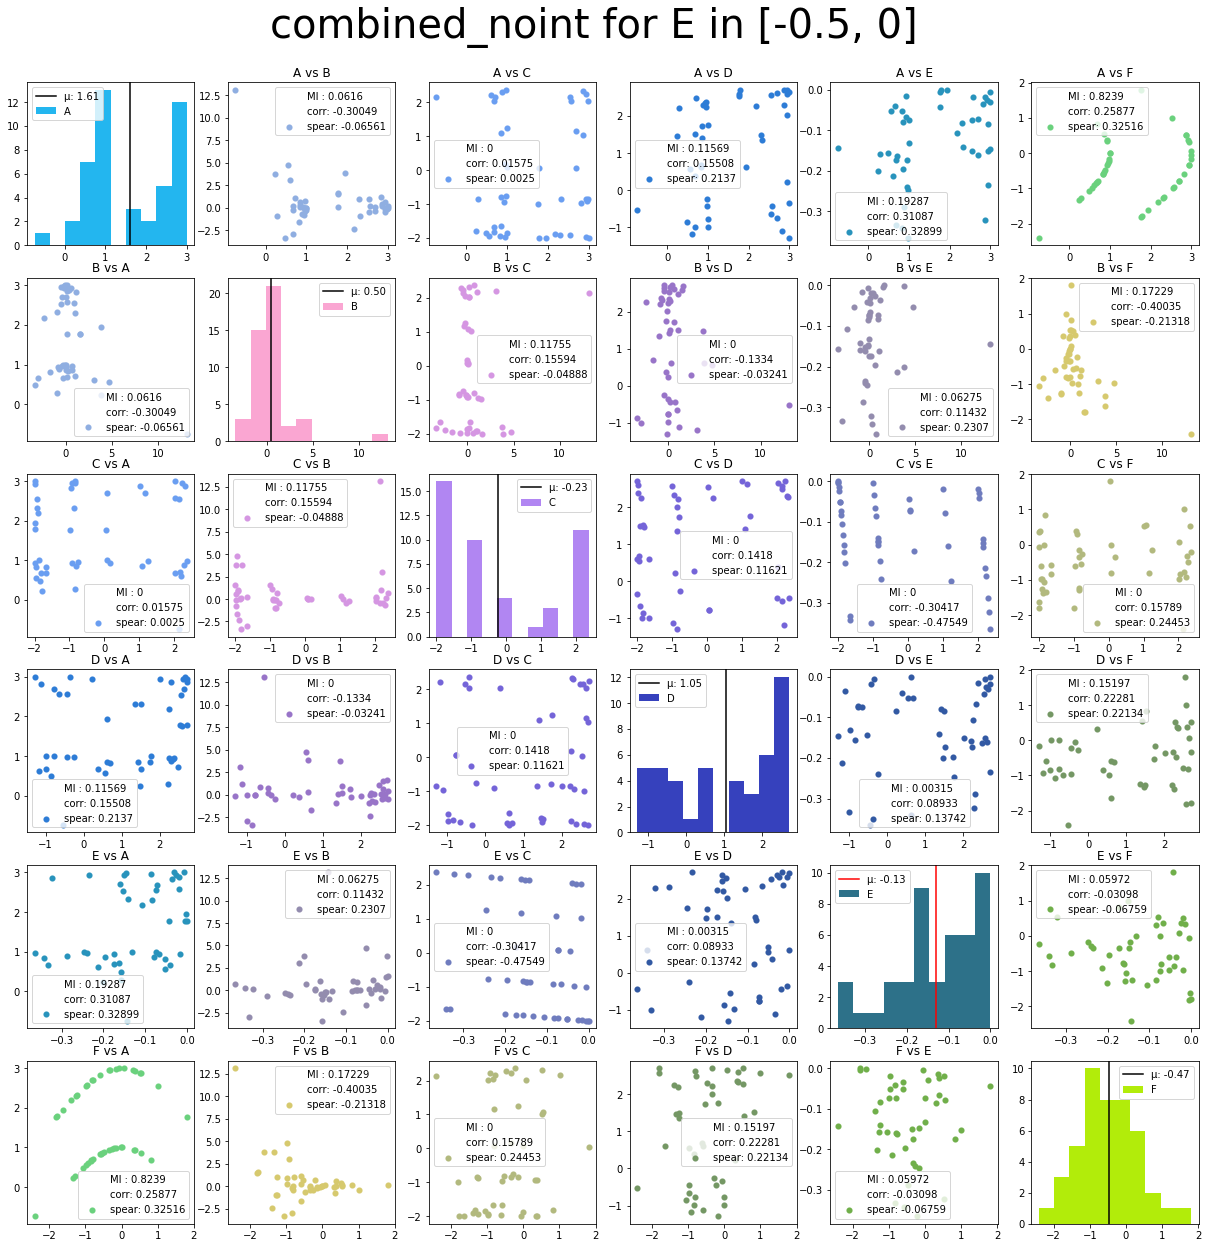

In [76]:
def conditioning_plots(data, conditioning_variable, conditioning_interval = [0,1], files = files, file_number = None):
    
    n_vars = len(list(data.columns))
    # colors = np.random.randint(0,255,(n_vars,3))/255

    fig, axs = plt.subplots(n_vars,n_vars,figsize=(21,21))
    names = ["A","B","C","D","E","F"]

    cont_var = np.array(data[conditioning_variable])
    idxs = np.where(np.logical_and(cont_var >= min(conditioning_interval),cont_var <= max(conditioning_interval)))

    for i,axs_i in enumerate(axs):
        for j,ax in enumerate(axs_i):

            x = np.array(data[vars[i]])[idxs]
            y = np.array(data[vars[j]])[idxs]
            
            if i != j:
                ax.scatter(x,y,linewidths =0.1,color=(colors[i]+colors[j])/2)
                ax.axvline(np.mean(x), color='black', alpha = 0)
                ax.axvline(np.mean(x), color='blue', alpha = 0)

                ax.set_title(f'{vars[i]} vs {vars[j]}')

                mutual_score = np.round(sf.mutual_info_regression(x.reshape(-1,1),y),5)
                corr = np.round(np.corrcoef(x,y),5)
                spearman = np.round(st.spearmanr(x,y),5)
                ax.legend(labels=[f'MI : {mutual_score[0]}',f"corr: {corr[0,1]}",f"spear: {spearman[0]}"])

            else:
                mean_color = "red" if vars[i] == conditioning_variable else "black"
                ax.hist(x,color=colors[i])
                ax.axvline(np.mean(x), color=mean_color)
                ax.legend(labels=[ f'μ: {np.mean(x):.2f}', vars[i]])


    if file_number is not None:
        fig.suptitle(f"{files[file_number][:-4]} for {conditioning_variable} in {conditioning_interval}",fontsize = 40,y=0.93)
                


conditioning_plots(data_files[13], conditioning_variable = "E", conditioning_interval = [-0.5,0], files = files, file_number = 13)


In [ ]:
f = np.array(data_files[13]["F"])
d = np.array(data_files[13]["D"])

b = np.array(data_files[13]["B"])

idxs = np.where(np.logical_and(b >= -5,b <= 5))

plt.scatter(d[idxs],f[idxs])
np.corrcoef(d[idxs],f[idxs])
mutual_score = np.round(sf.mutual_info_regression(x,y),10)

In [14]:
AA = data_files[11]
BB = data_files[files.index("combined_noint.csv")]

st.ttest_ind(AA["A"],BB["F"])

Ttest_indResult(statistic=15.745976646074505, pvalue=6.714912253982361e-35)

In [15]:
# Normal hists
def plot_hists():
    fig, axs = plt.subplots(n_vars,figsize=(15,15))
    print(type(axs))
    for i,ax in enumerate(axs):
        ax.hist(data[vars[i]],np.arange(-30,30,1))
        ax.set_title(vars[i], fontsize = 20)

In [16]:
np.var(data['B'][data['B'] > -10])

4.654671511934819

In [17]:
# Linear Correlation
corre_matrix = np.zeros((n_vars,n_vars))
for i in range(n_vars):
    for j in range(n_vars):
        corre_matrix[i,j] = np.round(np.corrcoef(data[vars[i]]+1e-8,data[vars[j]]+1e-8)[0,1],3)
corre_matrix

array([[ 1.   , -0.128,  0.111, -0.01 ,  0.045,  0.222],
       [-0.128,  1.   ,  0.066, -0.133, -0.069, -0.188],
       [ 0.111,  0.066,  1.   ,  0.128, -0.063,  0.074],
       [-0.01 , -0.133,  0.128,  1.   ,  0.07 ,  0.186],
       [ 0.045, -0.069, -0.063,  0.07 ,  1.   , -0.041],
       [ 0.222, -0.188,  0.074,  0.186, -0.041,  1.   ]])

In [18]:
def MI(x,y,Nbins=21, names=None):
    bins = np.linspace(np.min(x),np.max(x),Nbins)
    eps=np.spacing(1)
    x_marginal = np.histogram(x,bins=bins)[0]
    x_marginal = x_marginal/x_marginal.sum()
    y_marginal = np.array(np.histogram(y,bins=bins)[0])
    y_marginal = y_marginal/y_marginal.sum()
    xy_joint = np.array(np.histogram2d(x,y,bins=(bins,bins))[0])
    xy_joint = xy_joint/xy_joint.sum()
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(xy_joint.T,origin='lower')
    plt.title('joint')
    plt.subplot(1,2,2)
    plt.imshow((x_marginal[:,None]*y_marginal[None,:]).T,origin='lower')
    plt.title('product of marginals')
    mi=np.sum(xy_joint*np.log(xy_joint/(x_marginal[:,None]*y_marginal[None,:]+eps)+eps))
    if names is None:
        plt.suptitle(f'Mutual information: {mi}')
    else:
        plt.suptitle(f'Mutual information between {names[0]}, {names[1]}: {mi:.3f}')
        plt.savefig(f'./img/{names[0]}-{names[1]}.png')
    return(mi)

In [19]:
# mi = np.zeros((n_vars,n_vars))
# names = np.zeros((n_vars,n_vars)).tolist()
# for key_i, i in enumerate(vars):
#     n = names[key_i]
#     for key_j, j in enumerate(vars):
#         if j!=i:
#             mi[key_i,key_j] = sf.mutual_info_regression(x,y)(data[i], data[j])
#         n[key_j] = (i,j)

In [20]:
# fig, axs = plt.subplots(n_vars,n_vars,figsize=(15,15),dpi=200)

# for i,axs_i in enumerate(axs):
#     for j,ax in enumerate(axs_i):
#         if i != j:
#             ax.imshow(plt.imread(f'./img/{vars[i]}-{vars[j]}.png'))
#             ax.set_title(f'{vars[i]} vs {vars[j]}')

In [21]:
import sklearn.feature_selection as sf
mutal_score_M = np.zeros((n_vars,n_vars))
for i in range(n_vars):
    for j in range(n_vars):
        x = np.array(data[vars[i]]).reshape((-1,1))
        y = np.array(data[vars[j]])
        mutal_score_M[i,j] = np.round(sf.mutual_info_regression(x,y),2)

print(mutal_score_M)

[[3.34 0.11 0.   0.13 0.14 1.55]
 [0.11 3.34 0.08 0.13 0.   0.17]
 [0.   0.08 3.34 0.   0.15 0.  ]
 [0.13 0.13 0.   3.34 0.06 0.22]
 [0.14 0.   0.15 0.06 3.34 0.13]
 [1.55 0.17 0.   0.22 0.13 3.34]]


In [22]:
data_files[0]

,A,B,C,D,E,F
0,0.609014,3.061655,2.213009,-1.184504,-0.213009,-0.915980
1,0.930247,-0.335145,-1.065010,2.268498,0.065010,-0.375711
2,2.162754,-3.219556,1.997786,0.787081,0.002214,-1.407315
3,0.853078,0.023807,1.079205,1.416264,-0.079205,0.548940
4,0.561281,4.747432,-1.947666,0.557904,-0.052334,-0.974863
...,...,...,...,...,...,...
95,1.738898,1.747547,1.986365,2.201968,0.013635,-1.834960
96,2.568373,0.181462,2.019180,-0.438149,-0.019180,-0.966270
97,2.573723,-0.308505,1.752930,0.678583,0.247070,-0.959752
98,0.681775,1.301305,-1.185818,-0.536277,0.185818,-0.820610


In [23]:
[print(i,file) for i,file in enumerate(files)];

0 100.csv
1 200.csv
2 30-B=0.csv
3 30-C=0.csv
4 30-C=1.csv
5 30-D=-2.csv
6 40-D=-2.csv
7 50-A=1.3.csv
8 50-E=2.csv
9 50-F=-1.5.csv
10 50-F=2.csv
11 70-D=1.csv
12 70-E=2-F=2.csv
13 combined_noint.csv
14 D_combined.csv


In [24]:
baseline = pd.concat((data_files[0]["D"],data_files[1]["D"]))

for i in range(len(files)):
    print(i,st.ks_2samp(baseline,data_files[i]["D"])[1].round(5))

0 0.96705
1 0.96705
2 0.48251
3 0.9411
4 0.6219
5 0.0
6 0.0
7 0.35047
8 0.8448
9 0.43808
10 0.07486
11 0.0
12 0.41581
13 0.96705
14 0.0


In [25]:
print(i,st.ks_2samp(data_files[2]["D"],data_files[12]["D"])[1].round(5))


14 0.99446


In [26]:
# # Prints all plots with comparison
# for i in range(len(files)):
#     pairwise_plots(data_files[i], combarison_data = data_files[files.index("combined_noint.csv")], file_number=i)


array([[1.        , 0.16011045],
       [0.16011045, 1.        ]])

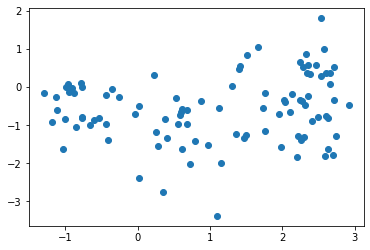

In [27]:
f = np.array(data_files[13]["F"])
d = np.array(data_files[13]["D"])

b = np.array(data_files[13]["B"])

idxs = np.where(np.logical_and(b >= -5,b <= 5))

plt.scatter(d[idxs],f[idxs])
np.corrcoef(d[idxs],f[idxs])

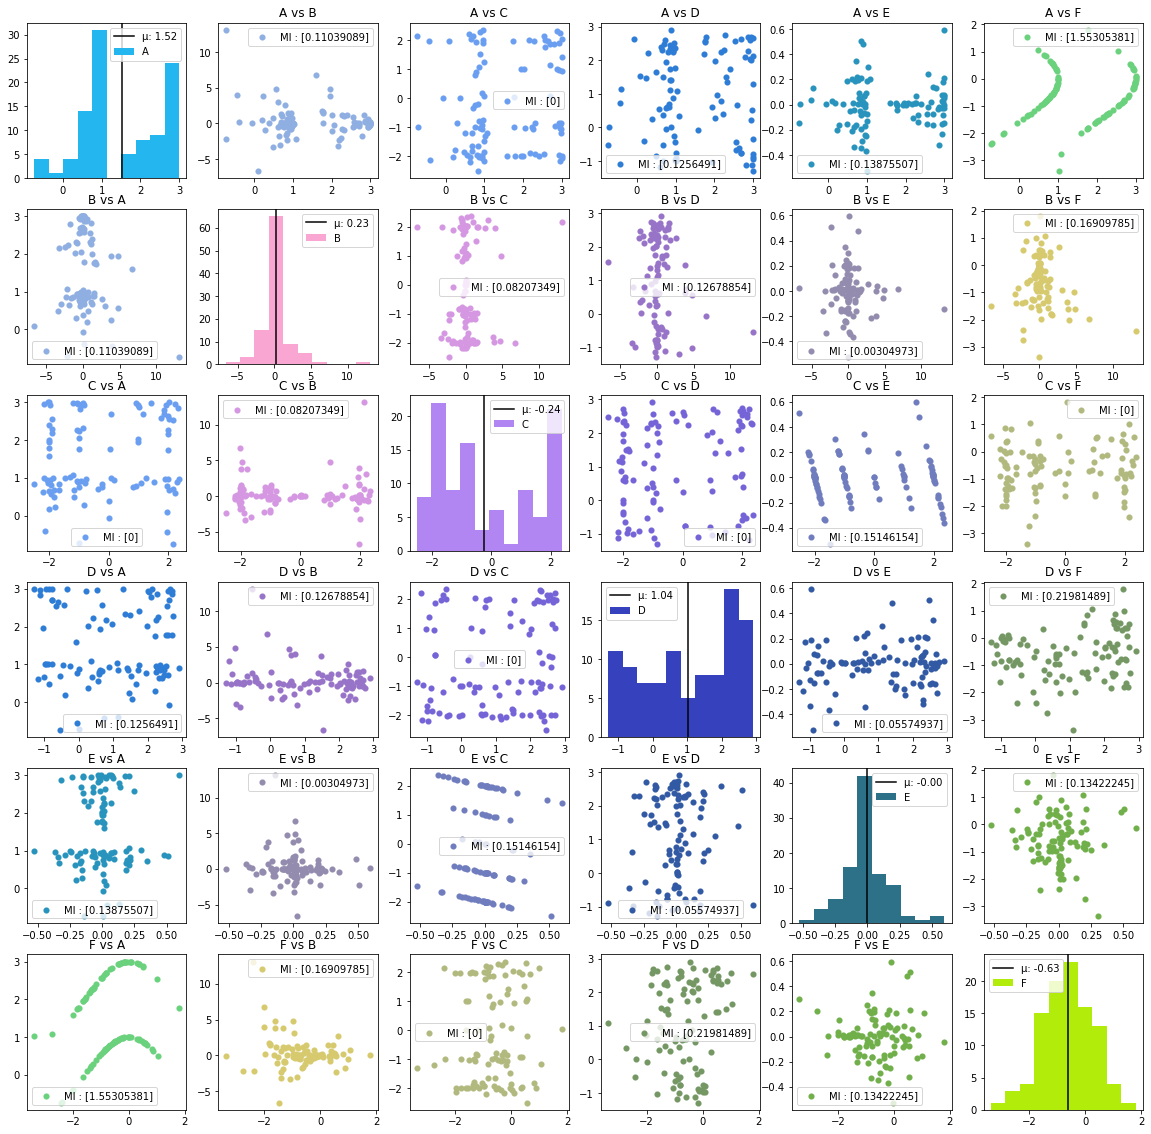

In [28]:
pairwise_plots(data)


0.8840955608688718

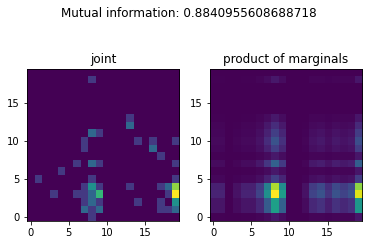

In [29]:
MI(data["A"],data["B"])

In [30]:
a = np.array(data["A"])
b = np.array(data["B"])

d = np.array(data["D"])

idxs = np.where(np.logical_and(d >= -0.5,d <= 0.5))

# plt.scatter(a[idxs],b[idxs])
# np.corrcoef(a[idxs],b[idxs])
# MI(np.array(data["A"])[idxs],np.array(data["B"])[idxs])
aa = np.array(data["A"])[idxs].reshape(-1,1)
bb = np.array(data["B"])[idxs]
print(sf.mutual_info_regression(aa,bb))
sf.mutual_info_regression(np.array(a).reshape(-1,1),b)


[0.05653273]


array([0.11039089])

In [31]:
data["A"]

0     0.609014
1     0.930247
2     2.162754
3     0.853078
4     0.561281
        ...   
95    1.738898
96    2.568373
97    2.573723
98    0.681775
99    2.056947
Name: A, Length: 100, dtype: float64